Messi - temporada 2008/2009 Primer Balón de Oro - 22 años
Lamine Yamal - ¿Llegará a conseguir algo similar antes de esa edad? ¿Ganará un Balón de Oro antes?

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [11]:
# Confirmar la raíz del proyecto
# Esto es necesario para que el código funcione correctamente en Jupyter Notebook

from pathlib import Path
import os

def find_project_root(marker_file="F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Evolve_Proyecto_Abril"):
    """Busca la raíz del proyecto basado en un archivo marcador."""
    current = Path.cwd().resolve()

    while current != current.parent:
        if (current / marker_file).exists():
            return current
        current = current.parent

    raise FileNotFoundError(f"No se encontró el archivo marcador {marker_file} en ninguna carpeta padre.")

# Usamos esto al inicio de cualquier archivo para fijar la raíz del proyecto
project_root = find_project_root()
os.chdir(project_root)  # OPCIONAL: cambia el cwd real si estás en Jupyter
print(f"📁 Carpeta raíz fijada a: {project_root}")



📁 Carpeta raíz fijada a: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril


In [12]:
# Raíz actualizada
# Cambiar el directorio de trabajo al directorio raíz del proyecto

import os
from pathlib import Path

# Cambiar al directorio raíz del proyecto (subí hasta donde esté "main.py" o ".git", etc.)
project_root = Path(os.getcwd()).resolve()

while not (project_root / "main.py").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print(f"📁 Working directory cambiado a: {project_root}")


📁 Working directory cambiado a: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril


In [ ]:
# Scraping de Lamine Yamal

import pandas as pd
import os

# URLs de las tres temporadas de Lamine
LAMINE_URLS = [
    "https://fbref.com/en/players/82ec26c1/matchlogs/2022-2023/Lamine-Yamal-Match-Logs",
    "https://fbref.com/en/players/82ec26c1/matchlogs/2023-2024/Lamine-Yamal-Match-Logs",
    "https://fbref.com/en/players/82ec26c1/matchlogs/2024-2025/Lamine-Yamal-Match-Logs"
]

def scrape_lamine_data(urls=LAMINE_URLS, output_path="data/raw/lamine_raw_data.csv"):
    all_data = []

    for url in urls:
        print(f"🌍 Scrapeando: {url}")
        try:
            df = pd.read_html(url, attrs={"id": "matchlogs_all"})[0]

            # Eliminar niveles innecesarios de encabezado
            if df.columns.nlevels > 1:
                df.columns = df.columns.get_level_values(-1)

            # Filtrar filas vacías
            df = df[df["Date"].notna()]

            # Añadir temporada a partir de la URL
            season = url.split("/")[-2]
            df["Season"] = season

            all_data.append(df)

        except Exception as e:
            print(f"❌ Error en {url}: {e}")

    if not all_data:
        print("⚠️ No se encontraron datos.")
        return None

    # Concatenar todos los datos
    df_yamal = pd.concat(all_data, ignore_index=True)

    # Guardar en carpeta /data/raw
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_yamal.to_csv(output_path, index=False)
    print(f"✅ CSV guardado en {output_path} con {len(df_yamal)} filas.")

    return df_yamal

In [59]:
scrape_lamine_data(urls=LAMINE_URLS, output_path="data/raw/lamine_raw_data.csv")
df_yamal = pd.read_csv("data/raw/lamine_raw_data.csv")
print(df_yamal.head(2))  # Verificar que se haya cargado correctamente

🌍 Scrapeando: https://fbref.com/en/players/82ec26c1/matchlogs/2022-2023/Lamine-Yamal-Match-Logs
🌍 Scrapeando: https://fbref.com/en/players/82ec26c1/matchlogs/2023-2024/Lamine-Yamal-Match-Logs
🌍 Scrapeando: https://fbref.com/en/players/82ec26c1/matchlogs/2024-2025/Lamine-Yamal-Match-Logs
✅ CSV guardado en data/raw/lamine_raw_data.csv con 117 filas.
         Date  Day     Comp         Round Venue Result      Squad  \
0  2023-04-23  Sun  La Liga  Matchweek 30  Home  W 1–0  Barcelona   
1  2023-04-26  Wed  La Liga  Matchweek 31  Away  L 1–2  Barcelona   

          Opponent Start                                  Pos  ...  \
0  Atlético Madrid     N  On matchday squad, but did not play  ...   
1   Rayo Vallecano     N  On matchday squad, but did not play  ...   

                                   Cmp                                  Att  \
0  On matchday squad, but did not play  On matchday squad, but did not play   
1  On matchday squad, but did not play  On matchday squad, but did not pl

In [60]:
# Procesar datos de Lamine Yamal

import pandas as pd
import os
from datetime import datetime
import re

def process_lamine_data(input_path="data/raw/lamine_raw_data.csv",
                        output_path="data/processed/lamine_cleaned_data.csv",
                        return_df=True):
    
    df_yamal = pd.read_csv(input_path)

    # 🎂 Fecha de nacimiento
    birthdate = pd.to_datetime("2007-07-13")

    # 📅 Convertir fecha
    df_yamal["Date"] = pd.to_datetime(df_yamal["Date"], errors="coerce")

    # 📅 Temporada
    def asignar_temporada(fecha):
        if pd.isna(fecha):
            return None
        year = fecha.year
        return f"{year}-{year + 1}" if fecha.month >= 8 else f"{year - 1}-{year}"
    df_yamal["Season"] = df_yamal["Date"].apply(asignar_temporada)

    # 🎂 Edad
    df_yamal["Age"] = df_yamal["Date"].apply(lambda d: round((d - birthdate).days / 365.25, 2) if pd.notna(d) else None)

    # 🏟️ Localía
    df_yamal["Home/Away"] = df_yamal["Venue"].apply(lambda v: "Home" if v == "Home" else "Away")

    # 🟡 Titular/Suplente
    df_yamal["Lineup"] = df_yamal["Start"].apply(lambda s: "Starter" if s == "Y" else "Substitute")

    # 🧽 Eliminar prefijos tipo 'pt Porto'
    df_yamal["Squad"] = df_yamal["Squad"].str.replace(r"^[a-z]{2}\s", "", regex=True)
    df_yamal["Opponent"] = df_yamal["Opponent"].str.replace(r"^[a-z]{2}\s", "", regex=True)

    # 🧱 Normalización de equipos
    TEAM_NAME_FIXES = {
        "Barcelona": "FC Barcelona",
        "Betis": "Real Betis",
        "Athletic Club": "Athletic de Bilbao",
        "Celta Vigo": "Celta de Vigo",
        "Paris S-G": "Paris Saint-Germain",
        "Shakhtar": "Shakhtar Donetsk",
        "Almeria": "UD Almería",
        "Porto": "FC Porto",
        "Mallorca": "Real Mallorca",
        "Antwerp": "Antwerp",
        "Osasuna": "Osasuna",
        "Napoli": "Napoli",
        "Las Palmas": "Las Palmas",
        "Granada": "Granada",
        "Valencia": "Valencia",
        "Real Sociedad": "Real Sociedad",
        "Atlético Madrid": "Atlético Madrid",
        "Real Madrid": "Real Madrid",
        "Sevilla": "Sevilla",
        "Girona": "Girona",
        "Alavés": "Alavés",
        "Rayo Vallecano": "Rayo Vallecano",
        "Getafe": "Getafe",
        "Cádiz": "Cádiz"
    }
    df_yamal["Squad"] = df_yamal["Squad"].replace(TEAM_NAME_FIXES)
    df_yamal["Opponent"] = df_yamal["Opponent"].replace(TEAM_NAME_FIXES)

    # 🧼 Limpiar resultado: solo marcador
    def limpiar_resultado(valor):
        if pd.isna(valor):
            return None
        valor = str(valor).strip()
        # Si comienza con W, D o L, hacer split por espacio y devolver la segunda parte
        if valor.startswith(("W", "D", "L")):
            partes = valor.split(" ")
            return partes[1] if len(partes) > 1 else None
        return valor

    # 🧼 Limpiar resultado: solo marcador
    df_yamal["Result"] = df_yamal["Result"].apply(limpiar_resultado)
    df_yamal["Result"] = df_yamal["Result"].str.replace("–", "-", regex=False)


    # 🏆 Normalizar competiciones
    COMP_FIXES = {
        "La Liga": "La Liga",
        "Champions Lg": "UEFA Champions League",
        "Copa del Rey": "Copa del Rey",
        "Supercopa de España": "Spanish Super Cup",
        "Friendlies (M)": "International friendly",
        "UEFA Nations League": "UEFA Nations League",
        "UEFA Euro Qualifying": "UEFA Euro Qualification",
        "UEFA Euro": "UEFA Euro"
    }
    df_yamal["Comp"] = df_yamal["Comp"].replace(COMP_FIXES)

    # 🧼 Ensamblar DataFrame final
    df_cleaned_yamal = pd.DataFrame()
    df_cleaned_yamal["Date"] = df_yamal["Date"]
    df_cleaned_yamal["Season"] = df_yamal["Season"]
    df_cleaned_yamal["Age"] = df_yamal["Age"]
    df_cleaned_yamal["Lamine_Team"] = "FC Barcelona"
    df_cleaned_yamal["Home/Away"] = df_yamal["Home/Away"]
    df_cleaned_yamal["Competition"] = df_yamal["Comp"]
    df_cleaned_yamal["Home Team"] = df_yamal.apply(lambda row: row["Squad"] if row["Venue"] == "Home" else row["Opponent"], axis=1)
    df_cleaned_yamal["Result"] = df_yamal["Result"]
    df_cleaned_yamal["Away Team"] = df_yamal.apply(lambda row: row["Opponent"] if row["Venue"] == "Home" else row["Squad"], axis=1)
    df_cleaned_yamal["Lineup"] = df_yamal["Lineup"]

    for col in ["Min", "Gls", "Ast", "CrdY"]:
        df_cleaned_yamal[col] = pd.to_numeric(df_yamal.get(col, 0), errors="coerce").fillna(0).astype(int)

    df_cleaned_yamal.rename(columns={
        "Min": "Minutes",
        "Gls": "Goals",
        "Ast": "Assists",
        "CrdY": "Cards"
    }, inplace=True)

    # 💾 Exportar
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_cleaned_yamal.to_csv(output_path, index=False)
    print(f"✅ Datos procesados guardados en: {output_path}")

    if return_df:
        return df_cleaned_yamal



In [61]:
process_lamine_data(input_path="data/raw/lamine_raw_data.csv", output_path="data/processed/lamine_cleaned_data.csv", return_df=True)
df_cleaned_yamal = process_lamine_data(return_df=True)
print(df_cleaned_yamal.head())
print(f"✅ El DataFrame procesado tiene {len(df_cleaned_yamal)} filas.")

✅ Datos procesados guardados en: data/processed/lamine_cleaned_data.csv
✅ Datos procesados guardados en: data/processed/lamine_cleaned_data.csv
        Date     Season    Age   Lamine_Team Home/Away Competition  \
0 2023-04-23  2022-2023  15.78  FC Barcelona      Home     La Liga   
1 2023-04-26  2022-2023  15.79  FC Barcelona      Away     La Liga   
2 2023-04-29  2022-2023  15.79  FC Barcelona      Home     La Liga   
3 2023-05-02  2022-2023  15.80  FC Barcelona      Home     La Liga   
4 2023-08-13  2023-2024  16.08  FC Barcelona      Away     La Liga   

        Home Team Result        Away Team      Lineup  Minutes  Goals  \
0    FC Barcelona    1-0  Atlético Madrid  Substitute        0      0   
1  Rayo Vallecano    1-2     FC Barcelona  Substitute        0      0   
2    FC Barcelona    4-0       Real Betis  Substitute        8      0   
3    FC Barcelona    1-0          Osasuna  Substitute        0      0   
4          Getafe    0-0     FC Barcelona  Substitute       15      0 

In [13]:
# Scraping de Messi

from pathlib import Path
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

# Lista de URLs que querés scrapear
URL_LIST = [
    "https://www.messistats.com/en/games/0/0/all/0/2/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/3/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/4/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/5/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/6/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/7/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/8/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/9/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/10/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/11/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/12/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/13/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/14/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/15/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/16/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/17/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/18/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/19/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/20/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/21/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/24/0/t/0/0/0/1",
]

def scrape_messi_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    headers = [
        "Index", "Date", "Competition", "Home Team", "Result", "Away Team",
        "Lineup", "Minutes", "Goals", "Assists", "Cards", "Jersey", "Extra"
    ]

    data = []
    for row in soup.find_all("tr"):
        cols = [col.text.strip() for col in row.find_all("td")]
        if cols:
            data.append(cols)

    if not data:
        return pd.DataFrame()  # Nada que agregar

    df_new = pd.DataFrame(data, columns=headers[:len(data[0])])
    return df_new

def scrape_multiple_urls(url_list=URL_LIST):
    all_data = []

    for url in url_list:
        print(f"🌐 Scrapeando: {url}")
        df_url = scrape_messi_data(url)
        if not df_url.empty:
            all_data.append(df_url)

    if not all_data:
        print("⚠️ No se encontraron datos.")
        return

    df_total = pd.concat(all_data, ignore_index=True)

    if raw_path.exists():
        df_existing = pd.read_csv(raw_path, dtype=str, on_bad_lines='skip')
        df_combined = pd.concat([df_existing, df_total], ignore_index=True)
    else:
        df_combined = df_total

    # Eliminar duplicados por campos clave
    df_combined.drop_duplicates(subset=["Date", "Home Team", "Away Team"], keep="last", inplace=True)
    df_combined.to_csv(raw_path, index=False, encoding="utf-8")
    print(f"✅ CSV actualizado: {raw_path} con {len(df_combined)} registros.")
    return df_combined



In [14]:
from src.scraping import scrape_multiple_urls

df_raw = scrape_multiple_urls()

print(f"✅ Total de filas scrapadas y guardadas: {len(df_raw)}")
df_raw.head(10)


🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/2/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/3/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/4/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/5/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/6/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/7/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/8/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/9/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/10/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/11/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/12/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/13/0/t/0/0/0/1
🌐 Scrapeando: https://www.messistats.com/en/games/0/0/all/0/14/0/t/0/0/0/1
🌐 Scrapeando: https://www.messist

,Index,Date,Competition,Home Team,Result,Away Team,Lineup,Minutes,Goals,Assists,Cards,Jersey,Extra
1091,9,01-05-2005,PRM \n ...,FC Barcelona,2-0,Albacete,SU \n ...,3,1,0,0,30,
1092,8,17-04-2005,PRM \n ...,FC Barcelona,2-0,Getafe,SU \n ...,5,0,0,0,30,
1093,7,21-12-2004,PRM \n ...,FC Barcelona,2-1,Levante,SU \n ...,33,0,0,0,30,
1094,6,11-12-2004,PRM \n ...,Albacete,1-2,FC Barcelona,SU \n ...,1,0,0,0,30,
1095,5,07-12-2004,EUR \n ...,Shakhtar Donetsk,2-0,FC Barcelona,ST \n ...,90,0,0,0,30,
1096,4,04-12-2004,PRM \n ...,FC Barcelona,4-0,Málaga,SU \n ...,8,0,0,0,30,
1097,3,27-10-2004,CUP \n ...,Gramenet,1-0,FC Barcelona,ST \n ...,72,0,0,0,30,
1098,2,24-10-2004,PRM \n ...,FC Barcelona,3-0,Osasuna,SU \n ...,18,0,0,0,30,
1099,1,16-10-2004,PRM \n ...,Espanyol,0-1,FC Barcelona,SU \n ...,7,0,0,0,30,
1100,35,24-06-2006,WCP \n ...,Argentina,2-1,Mexico,SU \n ...,37,0,0,0,19,


In [15]:
import pandas as pd
import os
from datetime import datetime

def process_data(input_path="data/raw/messi_raw_data.csv", output_path="data/processed/messi_cleaned_data.csv", return_df=True):
    """Procesa los datos sucios de Messi y los guarda limpios en la carpeta processed."""

    # Crear la carpeta 'processed' si no existe
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Leer el archivo CSV
    df = pd.read_csv(input_path)

    # Limpiar texto de Competition y Lineup
    df["Competition"] = df["Competition"].apply(lambda x: x.split("\n")[1].strip() if isinstance(x, str) and "\n" in x else x)
    df["Lineup"] = df["Lineup"].apply(lambda x: x.split("\n")[1].strip() if isinstance(x, str) and "\n" in x else x)

    # Eliminar columnas irrelevantes
    df.drop(columns=["Index", "Jersey", "Extra"], inplace=True, errors="ignore")

    # Convertir numéricos
    for col in ["Goals", "Assists", "Cards", "Minutes"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Convertir fechas
    df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce", dayfirst=True)

    # 📅 Calcular columna Season (considerando temporada COVID)
    def asignar_temporada(fecha):
        if pd.isna(fecha):
            return None
        if datetime(2019, 8, 15) <= fecha <= datetime(2020, 8, 14):
            return "2019-2020"
        year = fecha.year
        if fecha >= datetime(year, 8, 1):
            return f"{year}-{year + 1}"
        else:
            return f"{year - 1}-{year}"

    df["Season"] = df["Date"].apply(asignar_temporada)

    # 🎂 Calcular edad de Messi en cada partido
    birthdate = pd.to_datetime("1987-06-24")
    df["Age"] = df["Date"].apply(lambda d: round((d - birthdate).days / 365.25, 2) if pd.notna(d) else None)

    # 🏟️ Clasificar equipo de Messi por temporada
    def clasificar_equipo(season, competition):
        if pd.isna(season) or pd.isna(competition):
            return "Unknown"
        if "argentina" in competition.lower() or "national" in competition.lower():
            return "Argentina"
        elif season <= "2020-2021":
            return "FC Barcelona"
        elif season in ["2021-2022", "2022-2023"]:
            return "Paris Saint-Germain"
        elif season >= "2023-2024":
            return "Inter Miami"
        return "Unknown"

    df["Messi_Team"] = df.apply(lambda row: clasificar_equipo(row["Season"], row["Competition"]), axis=1)

    # 🏠 Clasificar como Home o Away
    def fue_local(row):
        if pd.isna(row["Home Team"]) or pd.isna(row["Messi_Team"]):
            return "Unknown"
        return "Home" if row["Home Team"] == row["Messi_Team"] else "Away"

    df["Home/Away"] = df.apply(fue_local, axis=1)

    # Reordenar columnas
    cols = ["Date", "Season", "Age", "Messi_Team", "Home/Away"] + [
        col for col in df.columns if col not in ["Date", "Season", "Age", "Messi_Team", "Home/Away"]
    ]
    df = df[cols]

    # Validaciones
    if df["Date"].isna().sum() > 0:
        print("⚠️ Fechas inválidas encontradas:")
        print(df[df["Date"].isna()][["Date", "Home Team", "Away Team"]].head())

    if df["Minutes"].isna().sum() > 0:
        print("⚠️ Minutos inválidos encontrados:")
        print(df[df["Minutes"].isna()][["Minutes", "Home Team", "Away Team"]].head())

    # Rellenar nulos numéricos
    df["Minutes"] = df["Minutes"].fillna(0).astype(int)
    df["Goals"] = df["Goals"].fillna(0).astype(int)
    df["Assists"] = df["Assists"].fillna(0).astype(int)
    df["Cards"] = df["Cards"].fillna(0).astype(int)

    # Guardar resultado
    df.to_csv(output_path, index=False)
    print(f"✅ Datos procesados guardados en: {output_path}")

    if return_df:
        return df


In [16]:
process_data(input_path="data/raw/messi_raw_data.csv", output_path="data/processed/messi_cleaned_data.csv", return_df=True)

df_cleaned = process_data(return_df=True)
print(f"✅ El DataFrame procesado tiene {len(df_cleaned)} filas.")
df_cleaned.head()


✅ Datos procesados guardados en: data/processed/messi_cleaned_data.csv
✅ Datos procesados guardados en: data/processed/messi_cleaned_data.csv
✅ El DataFrame procesado tiene 1091 filas.


,Date,Season,Age,Messi_Team,Home/Away,Competition,Home Team,Result,Away Team,Lineup,Minutes,Goals,Assists,Cards
0,2005-05-01,2004-2005,17.85,FC Barcelona,Home,La Liga,FC Barcelona,2-0,Albacete,Substitute,3,1,0,0
1,2005-04-17,2004-2005,17.82,FC Barcelona,Home,La Liga,FC Barcelona,2-0,Getafe,Substitute,5,0,0,0
2,2004-12-21,2004-2005,17.49,FC Barcelona,Home,La Liga,FC Barcelona,2-1,Levante,Substitute,33,0,0,0
3,2004-12-11,2004-2005,17.47,FC Barcelona,Away,La Liga,Albacete,1-2,FC Barcelona,Substitute,1,0,0,0
4,2004-12-07,2004-2005,17.46,FC Barcelona,Away,UEFA Champions League,Shakhtar Donetsk,2-0,FC Barcelona,Starter,90,0,0,0


In [17]:
df = process_data(return_df=True)

# Filtrar solo temporada 2019-2020
temporada_covid = df[df["Season"] == "2019-2020"]

print(f"📊 Partidos en la temporada 2019-2020: {len(temporada_covid)}")
temporada_covid.head()

✅ Datos procesados guardados en: data/processed/messi_cleaned_data.csv
📊 Partidos en la temporada 2019-2020: 46


,Date,Season,Age,Messi_Team,Home/Away,Competition,Home Team,Result,Away Team,Lineup,Minutes,Goals,Assists,Cards
823,2020-08-14,2019-2020,33.14,FC Barcelona,Home,UEFA Champions League,FC Barcelona,2-8,Bayern München,Starter,90,0,0,0
824,2020-08-08,2019-2020,33.13,FC Barcelona,Home,UEFA Champions League,FC Barcelona,3-1,Napoli,Starter,90,1,0,0
825,2020-07-19,2019-2020,33.07,FC Barcelona,Away,La Liga,Alavés,0-5,FC Barcelona,Starter,90,2,1,0
826,2020-07-16,2019-2020,33.06,FC Barcelona,Home,La Liga,FC Barcelona,1-2,Osasuna,Starter,90,1,0,0
827,2020-07-11,2019-2020,33.05,FC Barcelona,Away,La Liga,Real Valladolid,0-1,FC Barcelona,Starter,90,0,1,0


In [18]:
print(f"📅 Primer partido: {temporada_covid['Date'].min().date()}")
print(f"📅 Último partido: {temporada_covid['Date'].max().date()}")

📅 Primer partido: 2019-09-17
📅 Último partido: 2020-08-14


In [19]:
# Cargar el CSV limpio en un DataFrame
df_cleaned = pd.read_csv('data/processed/messi_cleaned_data.csv')

# Ver las primeras filas para verificar que todo está bien
print(df_cleaned.head())


         Date     Season    Age    Messi_Team Home/Away  \
0  2005-05-01  2004-2005  17.85  FC Barcelona      Home   
1  2005-04-17  2004-2005  17.82  FC Barcelona      Home   
2  2004-12-21  2004-2005  17.49  FC Barcelona      Home   
3  2004-12-11  2004-2005  17.47  FC Barcelona      Away   
4  2004-12-07  2004-2005  17.46  FC Barcelona      Away   

             Competition         Home Team Result     Away Team      Lineup  \
0                La Liga      FC Barcelona    2-0      Albacete  Substitute   
1                La Liga      FC Barcelona    2-0        Getafe  Substitute   
2                La Liga      FC Barcelona    2-1       Levante  Substitute   
3                La Liga          Albacete    1-2  FC Barcelona  Substitute   
4  UEFA Champions League  Shakhtar Donetsk    2-0  FC Barcelona     Starter   

   Minutes  Goals  Assists  Cards  
0        3      1        0      0  
1        5      0        0      0  
2       33      0        0      0  
3        1      0        0

In [20]:
print(df_cleaned.columns)
# Mostrar el tipo de dato de la columna date
print(df_cleaned['Date'].dtype)

Index(['Date', 'Season', 'Age', 'Messi_Team', 'Home/Away', 'Competition',
       'Home Team', 'Result', 'Away Team', 'Lineup', 'Minutes', 'Goals',
       'Assists', 'Cards'],
      dtype='object')
object


In [21]:
import pandas as pd
from datetime import datetime

# Leer el archivo CSV correcto (data/processed/messi_cleaned_data.csv)
df_cleaned = pd.read_csv("data/processed/messi_cleaned_data.csv")

# Asegúrate de que la columna 'Date' esté en formato string (si no lo está)
df_cleaned['Date'] = df_cleaned['Date'].astype(str)

# Usar datetime para cambiar el formato de fecha de 'YYYY-MM-DD' a 'DD-MM-YYYY'
df_cleaned['Date'] = df_cleaned['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").strftime("%d-%m-%Y"))

# Ahora que la fecha está en el formato correcto, convertirla a datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d-%m-%Y', errors='coerce')

# Mostrar las primeras filas para verificar que todo está correcto
print(df_cleaned[['Date']].head())

# Guardar el DataFrame actualizado en el archivo CSV correcto
df_cleaned.to_csv("data/processed/messi_cleaned_data.csv", index=False)

# Mostrar el tipo de dato de la columna date
print(df_cleaned['Date'].dtype)



        Date
0 2005-05-01
1 2005-04-17
2 2004-12-21
3 2004-12-11
4 2004-12-07
datetime64[ns]


In [22]:
import pandas as pd

# Filtrar partidos donde el Barcelona fue local o visitante
rivales_local = df_cleaned[df_cleaned["Home Team"] == "FC Barcelona"]["Away Team"]
rivales_visitante = df_cleaned[df_cleaned["Away Team"] == "FC Barcelona"]["Home Team"]

# Unir ambas listas y eliminar duplicados
rivales = pd.concat([rivales_local, rivales_visitante]).drop_duplicates().reset_index(drop=True)

# Ajustar el límite de filas que pandas puede mostrar
pd.set_option('display.max_rows', None)  # Esto asegura que todas las filas se muestren

# Mostrar listado completo de rivales
print("Lista de rivales del FC Barcelona:")
print(rivales)



Lista de rivales del FC Barcelona:
0                     Albacete
1                       Getafe
2                      Levante
3                       Málaga
4                      Osasuna
5                      Chelsea
6                   Real Betis
7              Atlético Madrid
8                Real Zaragoza
9                       Alavés
10          Athletic de Bilbao
11               Celta de Vigo
12                     Sevilla
13            Racing Santander
14               Panathinaikos
15                     Udinese
16                    Espanyol
17               Real Mallorca
18         Deportivo La Coruña
19                 Real Madrid
20                   Liverpool
21                    Valencia
22           Manchester United
23                      Celtic
24                  Villarreal
25           Recreativo Huelva
26             Glasgow Rangers
27                  UD Almería
28          Olympique Lyonnais
29              Bayern München
30              Sporting Gijón
31  

In [23]:
# Filtrar partidos donde el Barcelona fue local
partidos_locales = df_cleaned[df_cleaned['Home Team'] == 'FC Barcelona']  # Ajusta 'FC Barcelona' si es necesario

# Sumar los goles de Messi en esos partidos
total_goles_locales = partidos_locales['Goals'].sum()

print(f"Total de goles de Messi en los partidos donde el Barcelona fue local: {total_goles_locales}")



Total de goles de Messi en los partidos donde el Barcelona fue local: 400


In [24]:
# Filtrar partidos donde el Barcelona fue visitante
partidos_visitantes = df_cleaned[df_cleaned['Away Team'] == 'FC Barcelona']  # Ajusta 'FC Barcelona' si es necesario

# Sumar los goles de Messi en esos partidos
total_goles_visitantes = partidos_visitantes['Goals'].sum()

print(f"Total de goles de Messi en los partidos donde el Barcelona fue local: {total_goles_visitantes}")

Total de goles de Messi en los partidos donde el Barcelona fue local: 272


In [25]:
# Total de goles en la temporada
total_goles = df_cleaned['Goals'].sum()
print(f"Total de goles de Messi en la carrera: {total_goles}")


Total de goles de Messi en la carrera: 856


Total de goles de Messi en la carrera: 856

📈 Goles por año:
 Year
2004     0
2005     3
2006    12
2007    31
2008    22
2009    41
2010    60
2011    59
2012    91
2013    45
2014    58
2015    52
2016    59
2017    54
2018    51
2019    50
2020    27
2021    43
2022    35
2023    28
2024    29
2025     6
Name: Goals, dtype: int64


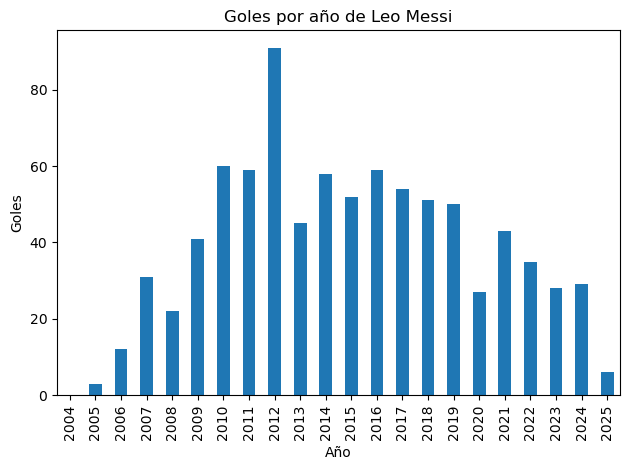

In [26]:
import matplotlib.pyplot as plt

# Total de goles
total_goles = df_cleaned['Goals'].sum()
print(f"Total de goles de Messi en la carrera: {total_goles}")

# Goles por año
df_cleaned["Year"] = df_cleaned["Date"].dt.year
goles_por_año = df_cleaned.groupby("Year")["Goals"].sum()
print("\n📈 Goles por año:\n", goles_por_año)

# Gráfico de Goles por año
goles_por_año.plot(kind="bar", title="Goles por año de Leo Messi")
plt.ylabel("Goles")
plt.xlabel("Año")
plt.tight_layout()
plt.show()


Total de goles de Messi en la carrera: 856

📅 Goles por temporada:
 Season
2004-2005     1
2005-2006    10
2006-2007    21
2007-2008    19
2008-2009    41
2009-2010    48
2010-2011    57
2011-2012    82
2012-2013    69
2013-2014    48
2014-2015    62
2015-2016    50
2016-2017    57
2017-2018    52
2018-2019    54
2019-2020    33
2020-2021    44
2021-2022    22
2022-2023    40
2023-2024    28
2024-2025    18
Name: Goals, dtype: int64


<Axes: title={'center': 'Total de Goles por Temporada'}, xlabel='Temporada', ylabel='Goles'>

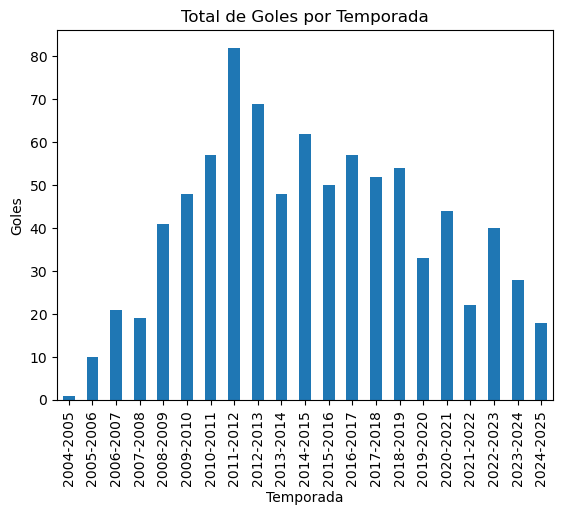

In [27]:
# Total de goles en la temporada
total_goles = df_cleaned['Goals'].sum()
print(f"Total de goles de Messi en la carrera: {total_goles}")

#Goles por temporada
goles_por_temporada = df_cleaned.groupby("Season")["Goals"].sum()
print("\n📅 Goles por temporada:\n", goles_por_temporada)

# Gráfico de Goles por temporada
goles_por_temporada = df_cleaned.groupby('Season')['Goals'].sum()
goles_por_temporada.plot(kind='bar', title='Total de Goles por Temporada', xlabel='Temporada', ylabel='Goles')



🏆 Top competiciones con más goles:
 Competition
La Liga                   474
UEFA Champions League     129
Copa del Rey               56
International friendly     51
Major League Soccer        24
Name: Goals, dtype: int64


<Axes: title={'center': 'Top competiciones con más goles de Leo Messi'}, xlabel='Competition'>

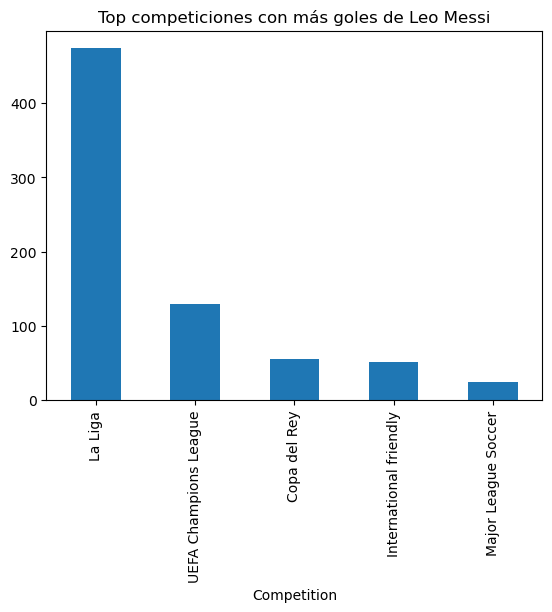

In [28]:
# Top competiciones con más goles
top_competiciones = df_cleaned.groupby("Competition")["Goals"].sum().sort_values(ascending=False).head(5)
print("\n🏆 Top competiciones con más goles:\n", top_competiciones)

# Gráfico de Top competiciones con más goles
top_competiciones.plot(kind="bar", title="Top competiciones con más goles de Leo Messi")

In [29]:
# Asegurarnos de que 'Minutos' es numérico y luego calcular el promedio de goles por minuto
df_cleaned['Minutes'] = pd.to_numeric(df_cleaned['Minutes'], errors='coerce')  # Convertir Minutos a numérico

# Total de minutos jugados
total_minutos = df_cleaned['Minutes'].sum()

# Promedio de goles por minuto (total de goles / total de minutos jugados)
promedio_goles_por_minuto = total_minutos / total_goles if total_goles > 0 else 0

# Mostrar los resultados
print(f"Promedio de goles de Messi por minuto: Metió un gol cada {promedio_goles_por_minuto:.2f} minutos.")

Promedio de goles de Messi por minuto: Metió un gol cada 104.50 minutos.


In [30]:
promedio_goles = df_cleaned['Goals'].mean()
print(f"Promedio de goles por partido: {promedio_goles}")


Promedio de goles por partido: 0.7846012832263978



🏆 Goles totales por competición:
 Competition
La Liga                                474
UEFA Champions League                  129
Copa del Rey                            56
International friendly                  51
Major League Soccer                     24
Ligue 1                                 22
Spanish Super Cup                       14
Leagues Cup                             10
World Cup 2014 Qualification            10
World Cup 2022 Qualification             7
World Cup 2022                           7
World Cup 2018 Qualification             7
World Cup 2026 Qualification             6
Concacaf Champions Cup                   5
Copa América Centenario                  5
FIFA Club World Cup                      5
World Cup 2014                           4
Copa América 2021                        4
World Cup 2010 Qualification             4
UEFA European Super Cup                  3
Copa América 2007                        2
World Cup 2018                           1
Copa Am

<Axes: title={'center': 'Goles por Competición'}, xlabel='Competición', ylabel='Goles'>

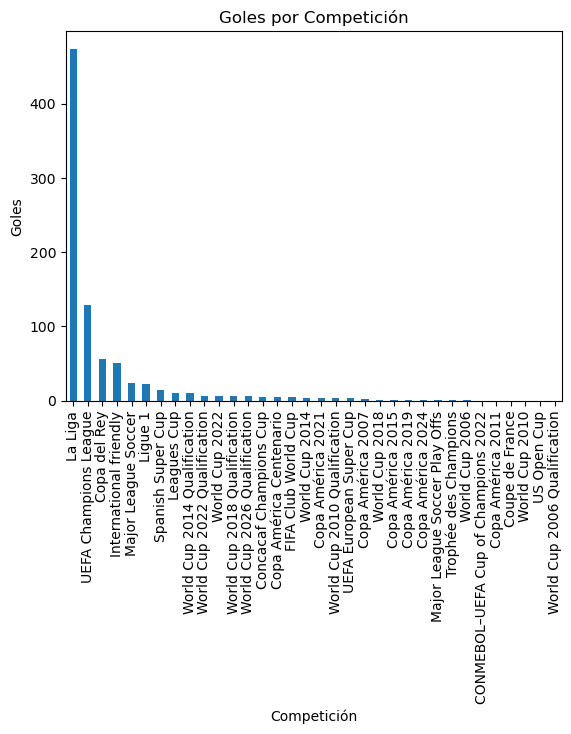

In [31]:
goles_por_competicion = df_cleaned.groupby('Competition')['Goals'].sum()
# Mostrar los goles por competición ordenados de mayor a menor
goles_por_competicion = goles_por_competicion.sort_values(ascending=False)
print("\n🏆 Goles totales por competición:\n", goles_por_competicion)
goles_por_competicion.plot(kind='bar', title='Goles por Competición', xlabel='Competición', ylabel='Goles')


Total de asistencias de Messi en la carrera: 382

🏆 Asistencias totales por temporada:
 Season
2011-2012    34
2014-2015    32
2010-2011    29
2015-2016    27
2022-2023    26
2019-2020    26
2017-2018    21
2018-2019    20
2008-2009    19
2012-2013    18
2016-2017    18
2020-2021    17
2023-2024    17
2021-2022    16
2013-2014    16
2007-2008    16
2009-2010    12
2024-2025     7
2005-2006     6
2006-2007     5
2004-2005     0
Name: Assists, dtype: int64


<Axes: title={'center': 'Total de Asistencias por Temporada'}, xlabel='Temporada', ylabel='Asistencias'>

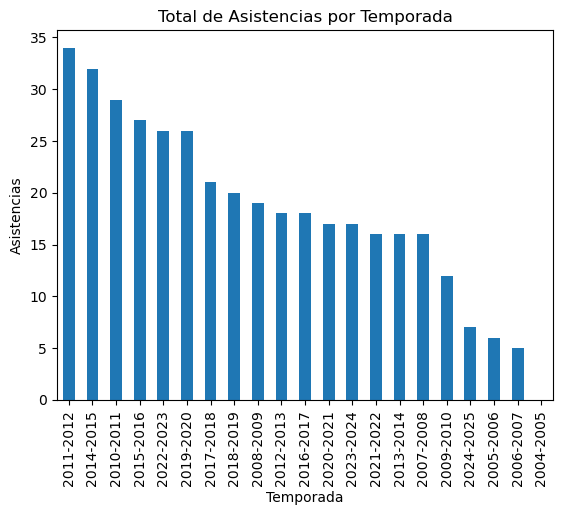

In [32]:
# Mostrar las asistencias totales
asistencias_totales = df_cleaned['Assists'].sum()
print(f"Total de asistencias de Messi en la carrera: {asistencias_totales}")

asistencias_por_temporada = df_cleaned.groupby('Season')['Assists'].sum()

# Mostrar las asistencias por competición ordenados de mayor a menor

asistencias_por_temporada = asistencias_por_temporada.sort_values(ascending=False)
print("\n🏆 Asistencias totales por temporada:\n", asistencias_por_temporada)
asistencias_por_temporada.plot(kind='bar', title='Total de Asistencias por Temporada', xlabel='Temporada', ylabel='Asistencias')


<Axes: title={'center': 'Goles por Mes'}, xlabel='Mes', ylabel='Goles'>

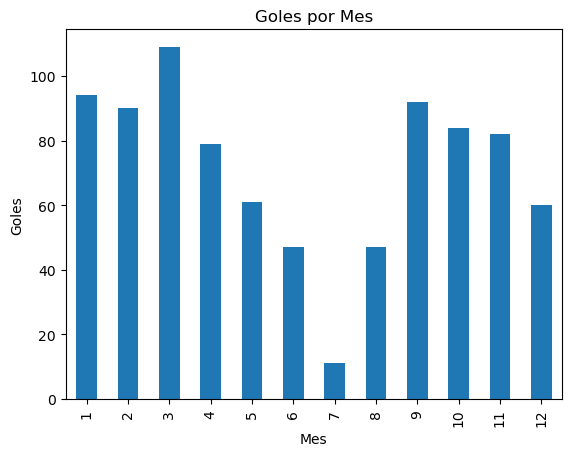

In [33]:
# Goles por mes

df_cleaned['Month'] = df_cleaned['Date'].dt.month
goles_por_mes = df_cleaned.groupby('Month')['Goals'].sum()
goles_por_mes.plot(kind='bar', title='Goles por Mes', xlabel='Mes', ylabel='Goles')


✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv

📊 Goles y asistencias - Home vs Away:
            Goals  Assists
Home/Away                
Away         404      224
Home         452      158
🖼️ Guardado: local_vs_visitante.png


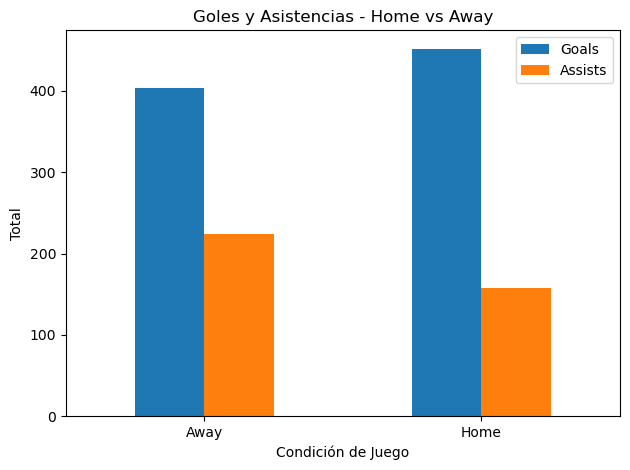

In [34]:
from src.processing import process_data
from src.analysis import plot_local_vs_visitante

# Obtener el DataFrame limpio
df = process_data(return_df=True)

# Mostrar y guardar el gráfico local vs visitante
plot_local_vs_visitante(df, save=True)



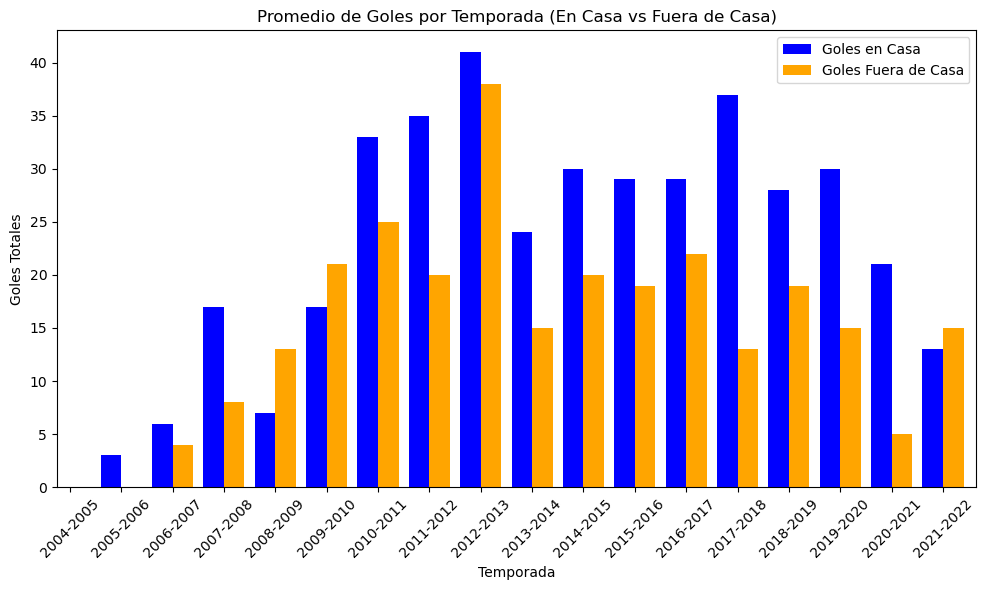

In [35]:
# Promedio de Goles por Temporada (Home vs Away)

# Filtrar goles por temporada
df_cleaned['Season'] = df_cleaned['Date'].dt.year.astype(str) + "-" + (df_cleaned['Date'].dt.year + 1).astype(str)

# Goles de Messi en casa (FC Barcelona como local)
goles_locales_season = df_cleaned[df_cleaned["Home Team"] == "FC Barcelona"].groupby("Season")["Goals"].sum()

# Goles de Messi fuera de casa (FC Barcelona como visitante)
goles_visitantes_season = df_cleaned[df_cleaned["Away Team"] == "FC Barcelona"].groupby("Season")["Goals"].sum()

# Graficar comparación de goles por temporada
plt.figure(figsize=(10, 6))
goles_locales_season.plot(kind='bar', label='Goles en Casa', width=0.4, position=1, color='blue')
goles_visitantes_season.plot(kind='bar', label='Goles Fuera de Casa', width=0.4, position=0, color='orange')
plt.title("Promedio de Goles por Temporada (En Casa vs Fuera de Casa)")
plt.xlabel("Temporada")
plt.ylabel("Goles Totales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


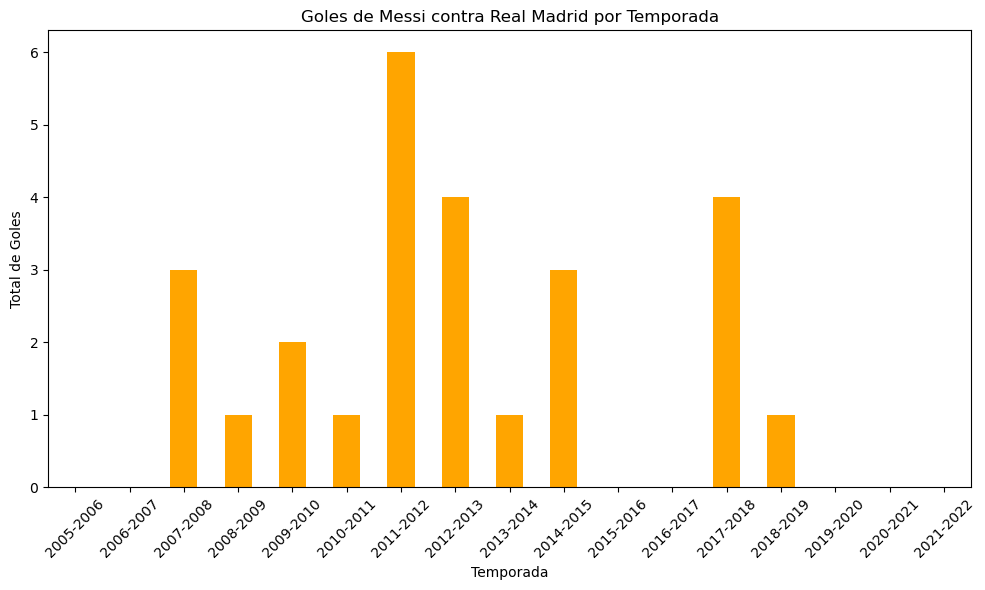

Season
2005-2006    0
2006-2007    0
2007-2008    3
2008-2009    1
2009-2010    2
2010-2011    1
2011-2012    6
2012-2013    4
2013-2014    1
2014-2015    3
2015-2016    0
2016-2017    0
2017-2018    4
2018-2019    1
2019-2020    0
2020-2021    0
2021-2022    0
Name: Goals, dtype: int64

In [36]:
# Número de Goles por Rival Específico

# Supongamos que quieres ver los goles contra el Real Madrid
rival_elegido = "Real Madrid"

# Goles contra el Real Madrid (como local o visitante)
goles_rival = df_cleaned[(df_cleaned["Home Team"] == "FC Barcelona") & (df_cleaned["Away Team"] == rival_elegido) | 
                         (df_cleaned["Away Team"] == "FC Barcelona") & (df_cleaned["Home Team"] == rival_elegido)]

# Graficar
goles_rival_season = goles_rival.groupby("Season")["Goals"].sum()
goles_rival_season.plot(kind='bar', color='orange', figsize=(10, 6))

plt.title(f"Goles de Messi contra {rival_elegido} por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Total de Goles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

goles_rival_season

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes 'goles_completos' y 'partidos_por_rival' como se discutió anteriormente

# Calcular el promedio de goles por rival
goles_completos["Promedio de Goles"] = goles_completos["Goles Totales"] / partidos_por_rival["Partidos Totales"]

# Mostrar los datos con goles totales, partidos totales y promedio de goles
goles_completos["Goles Totales"] = goles_completos["Goles Totales"].astype(int)
partidos_por_rival["Partidos Totales"] = partidos_por_rival["Partidos Totales"].astype(int)
goles_completos["Promedio de Goles"] = goles_completos["Promedio de Goles"].round(2)

# Unir los tres datos en un DataFrame para visualizar en una tabla antes de graficar
goles_completos = pd.concat([goles_completos["Goles Totales"], partidos_por_rival["Partidos Totales"], goles_completos["Promedio de Goles"]], axis=1)
goles_completos.columns = ["Goles Totales", "Partidos Totales", "Promedio de Goles"]

# Filtrar el Top 5 o mostrar todos los rivales
# Si quieres el Top 5, descomenta la siguiente línea:
goles_completos = goles_completos.nlargest(5, "Promedio de Goles")  # Muestra el Top 5 por Promedio de Goles

# Mostrar la tabla completa
print("Tabla completa de Goles Totales, Partidos Totales y Promedio de Goles por Rival:")
print(goles_completos)

# Graficar
goles_completos.sort_values(by="Promedio de Goles", ascending=False).plot(kind="bar", figsize=(12, 6))

# Personalizar el gráfico
plt.title("Goles Totales y Promedio de Goles de Messi por Rival")
plt.xlabel("Rival")
plt.ylabel("Goles Totales / Promedio de Goles")
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Mostrar los primeros valores para verificar los datos
print(goles_completos.head())




NameError: name 'goles_completos' is not defined

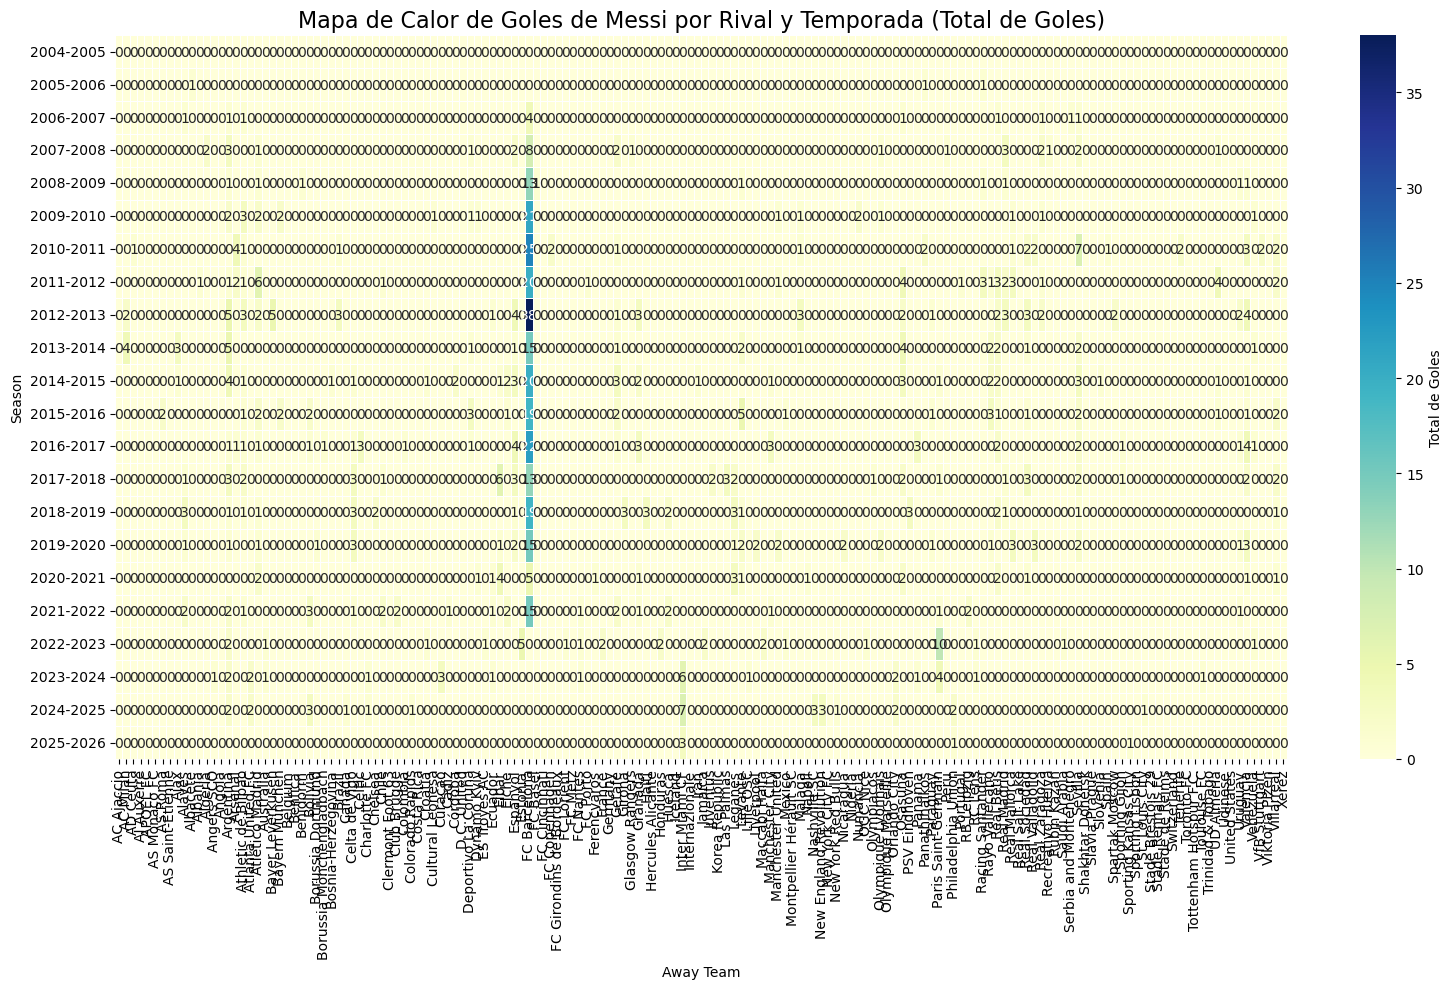

In [ ]:
# Mapa de Calor de Goles por Rival y Temporada (esta hay que revisarla, no me convence)

import seaborn as sns
import matplotlib.pyplot as plt

# Crear tabla de goles por temporada y rival
goles_por_rival_temporada = df_cleaned.groupby(["Season", "Away Team"])["Goals"].sum().unstack(fill_value=0)

# Crear gráfico de mapa de calor
plt.figure(figsize=(16, 10))  # Aumentamos el tamaño para mayor claridad
sns.heatmap(goles_por_rival_temporada, 
            cmap="YlGnBu",       # Paleta de colores ajustada
            annot=True,          # Incluir los valores dentro de las celdas
            fmt="d",             # Mostrar los valores como enteros
            linewidths=0.5,      # Líneas de separación entre las celdas
            cbar_kws={'label': 'Total de Goles'},  # Etiqueta del color bar
            xticklabels=goles_por_rival_temporada.columns,  # Etiquetas de los rivales
            yticklabels=goles_por_rival_temporada.index)   # Etiquetas de las temporadas

# Mejorar la presentación de los ejes
plt.xticks(rotation=90, fontsize=10)  # Rotar las etiquetas de los rivales
plt.yticks(rotation=0, fontsize=10)   # Mantener las etiquetas de las temporadas en horizontal

# Agregar un título claro y informativo
plt.title("Mapa de Calor de Goles de Messi por Rival y Temporada (Total de Goles)", fontsize=16)

# Ajustar el espacio para evitar que las etiquetas se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()



In [ ]:
# Rivales con Más Goles Anotados en un Solo Partido

# Filtrar partidos donde el Barcelona ha jugado contra el rival elegido
rivales_goles_maximos = df_cleaned[df_cleaned["Goals"] > 0]

# Obtener el máximo de goles por partido y por rival
goles_maximos = rivales_goles_maximos.groupby(["Home Team", "Away Team"])["Goals"].max()

# Mostrar los 10 partidos con más goles
print(goles_maximos.sort_values(ascending=False).head(10))


Home Team            Away Team       
Argentina            Estonia             5
FC Barcelona         Bayer Leverkusen    5
                     Eibar               4
                     Espanyol            4
                     Arsenal             4
                     Valencia            4
                     Osasuna             4
                     Celta de Vigo       3
Deportivo La Coruña  FC Barcelona        3
Ecuador              Argentina           3
Name: Goals, dtype: int64


In [ ]:
# 📦 Cargar variables de entorno desde .env (asegúrate de tener el archivo en la raíz del proyecto)
from dotenv import load_dotenv
import os
load_dotenv()

# ✅ Recuperar credenciales de la base de datos
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# 🛠️ Agregar carpeta src/ al path para poder importar módulos personalizados
import sys
from pathlib import Path

root_path = Path().resolve()  # Ajusta esto si estás dentro de otra carpeta como notebooks/
src_path = root_path / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# 🧩 Importar función para obtener el engine de conexión a MySQL
from db import get_engine

# ⚙️ Crear el engine de conexión
engine = get_engine()


In [ ]:
# 🧼 Importar función de procesamiento (desde src/processing.py)
from processing import process_data

# 🧠 Ejecutar la función para obtener el DataFrame procesado
df = process_data(return_df=True)

# 👀 Verificar columnas del DataFrame
print("Columnas del DataFrame:", df.columns.tolist())  # Confirmar que tenga "Home/Away" y demás

# 💾 Guardar el DataFrame en la base de datos
df.to_sql("messi_career_data", con=engine, if_exists="replace", index=False)

# 🔍 Comprobar que la tabla se creó correctamente
import pandas as pd
pd.read_sql("SHOW COLUMNS FROM messi_career_data;", engine)



✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv
Columnas del DataFrame: ['Date', 'Season', 'Messi_Team', 'Home/Away', 'Competition', 'Home Team', 'Result', 'Away Team', 'Lineup', 'Minutes', 'Goals', 'Assists', 'Cards']


,Field,Type,Null,Key,Default,Extra
0,Date,datetime,YES,,None,
1,Season,text,YES,,None,
2,Messi_Team,text,YES,,None,
3,Home/Away,text,YES,,None,
4,Competition,text,YES,,None,
5,Home Team,text,YES,,None,
6,Result,text,YES,,None,
7,Away Team,text,YES,,None,
8,Lineup,text,YES,,None,
9,Minutes,bigint,YES,,None,


In [ ]:
# Goles y asistencias por temporada

import pandas as pd
import plotly.express as px
from src.db import get_engine

engine = get_engine()

query = """
SELECT
  `Season`,
  SUM(`Goals`) AS Total_Goals,
  SUM(`Assists`) AS Total_Assists
FROM messi_career_data
GROUP BY `Season`
ORDER BY `Season`;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Season", y=["Total_Goals", "Total_Assists"],
             title="⚽ Goles y 🎯 Asistencias por Temporada",
             barmode="group")
fig.show()


In [ ]:
# Goles como local vs visitante

query = """
SELECT
  `Local/Visitante`,
  SUM(`Goals`) AS Total_Goals
FROM messi_career_data
GROUP BY `Local/Visitante`;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Local/Visitante", y="Total_Goals",
             title="🏠 Goles Local vs Visitante",
             text_auto=True, labels={"Total_Goals": "Goles"})
fig.update_layout(yaxis_title="Goles")
fig.show()


In [ ]:
# Goles por competición

query = """
SELECT
  `Competition`,
  SUM(`Goals`) AS Total_Goals
FROM messi_career_data
GROUP BY `Competition`
ORDER BY Total_Goals DESC;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Competition", y="Total_Goals",
             title="🏆 Goles por Competición",
             text_auto=True)
fig.update_layout(xaxis_tickangle=-45, yaxis_title="Goles")
fig.show()


In [ ]:
# Goles por mes (tendencia estacional)

query = """
SELECT
  MONTH(`Date`) AS Month,
  SUM(`Goals`) AS Total_Goals
FROM messi_career_data
GROUP BY MONTH(`Date`)
ORDER BY Month;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Month", y="Total_Goals",
             title="📅 Goles por Mes",
             labels={"Month": "Mes", "Total_Goals": "Goles"},
             text_auto=True)
fig.update_layout(yaxis_title="Goles", xaxis_title="Mes")
fig.show()


In [62]:
# Top 10 Total de Goles en Casa y Fuera de Casa por Rivales

import pandas as pd
import plotly.express as px
from src.db import get_engine

engine = get_engine()

query = """
SELECT
  sub.Rival,
  sub.`Home/Away`,
  SUM(sub.Goals) AS Total_Goals
FROM (
  SELECT *,
    CASE
      WHEN `Messi_Team` = `Home Team` THEN `Away Team`
      ELSE `Home Team`
    END AS Rival
  FROM messi_career_data
  WHERE `Messi_Team` IS NOT NULL
    AND (
      (`Messi_Team` = `Home Team` AND `Away Team` NOT IN ('Argentina', 'FC Barcelona', 'Paris Saint-Germain', 'Inter Miami CF'))
      OR
      (`Messi_Team` != `Home Team` AND `Home Team` NOT IN ('Argentina', 'FC Barcelona', 'Paris Saint-Germain', 'Inter Miami CF'))
    )
) AS sub
GROUP BY sub.Rival, sub.`Home/Away`
HAVING Rival IS NOT NULL
"""

df = pd.read_sql(query, engine)

# 🔢 Obtener los 10 rivales con más goles en total (Home + Away)
top10_rivales = (
    df.groupby("Rival")["Total_Goals"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 🔍 Filtrar solo esos 10
df_top10 = df[df["Rival"].isin(top10_rivales)]

# 🧽 Ordenar los rivales según la suma total para que Plotly los ordene bien
orden_rivales = (
    df_top10.groupby("Rival")["Total_Goals"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

# 🎨 Gráfico ordenado
fig = px.bar(
    df_top10,
    x="Rival",
    y="Total_Goals",
    color="Home/Away",
    category_orders={"Rival": orden_rivales},
    title="🔟 Rivales más goleados por Messi (Home vs Away)",
    text_auto=True,
    barmode="group"
)

fig.update_layout(
    xaxis_title="Rival",
    yaxis_title="Goles",
    xaxis_tickangle=-45
)

fig.show()


# Lamine Yamal

<Axes: title={'center': 'Goles y asistencias por temporada'}, xlabel='Season'>

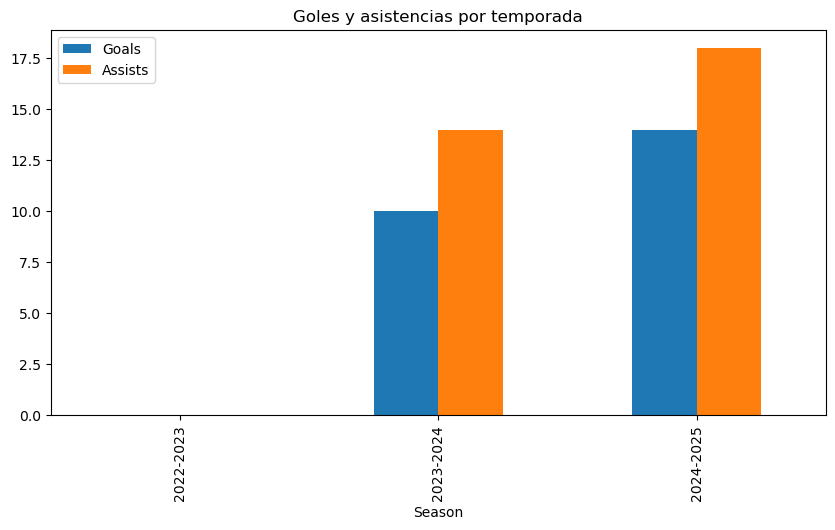

In [ ]:
# 📊 Goles y asistencias por edad

df_cleaned_yamal.groupby("Season")[["Goals", "Assists"]].sum().plot(kind="bar", figsize=(10, 5), title="Goles y asistencias por temporada")


<Axes: title={'center': 'Minutos jugados por temporada'}, xlabel='Season', ylabel='Minutos'>

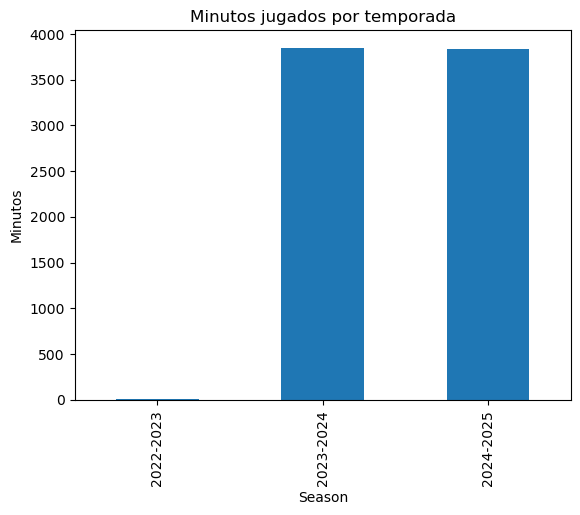

In [65]:
# 📈 Minutos jugados por temporada

df_cleaned_yamal.groupby("Season")["Minutes"].sum().plot(kind="bar", title="Minutos jugados por temporada", ylabel="Minutos")


<Axes: title={'center': 'Titular vs Suplente'}, ylabel='count'>

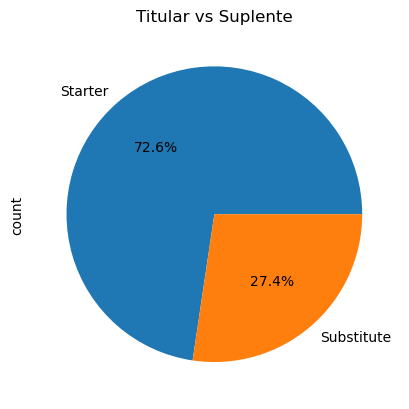

In [66]:
# ⚽ Distribución de titularidades vs suplencias

df_cleaned_yamal["Lineup"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Titular vs Suplente")


<Axes: title={'center': 'Local vs Visitante'}, xlabel='Home/Away'>

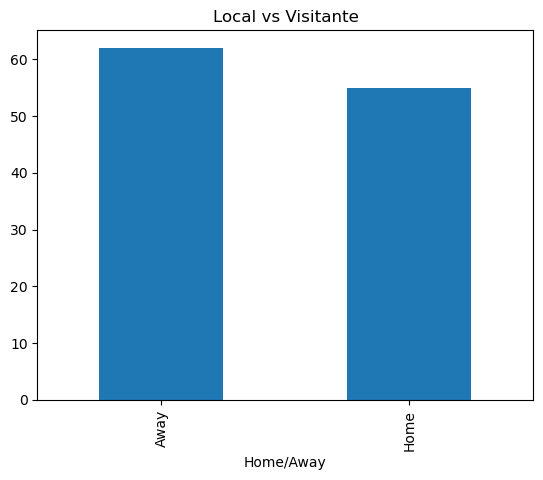

In [67]:
# 🏟️ Actuaciones como local vs visitante

df_cleaned_yamal["Home/Away"].value_counts().plot(kind="bar", title="Local vs Visitante")


<Axes: title={'center': 'Evolución de minutos por edad'}, xlabel='Age', ylabel='Minutes'>

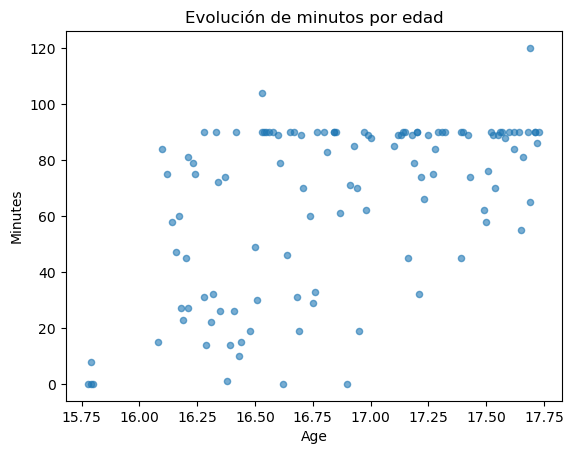

In [68]:
# 🧠 Evolución de minutos por partido (scatter por edad)

df_cleaned_yamal.plot.scatter(x="Age", y="Minutes", title="Evolución de minutos por edad", alpha=0.6)


# Comparativa Messi vs Lamine

In [71]:
print("📊 Comparativa rápida:")
print(f"Messi - Goles totales: {df_cleaned['Goals'].sum()}, Asistencias: {df_cleaned['Assists'].sum()}, Partidos: {len(df_cleaned)}")
print(f"Lamine - Goles totales: {df_cleaned_yamal['Goals'].sum()}, Asistencias: {df_cleaned_yamal['Assists'].sum()}, Partidos: {len(df_cleaned_yamal)}")



📊 Comparativa rápida:
Messi - Goles totales: 856, Asistencias: 382, Partidos: 1091
Lamine - Goles totales: 24, Asistencias: 32, Partidos: 117


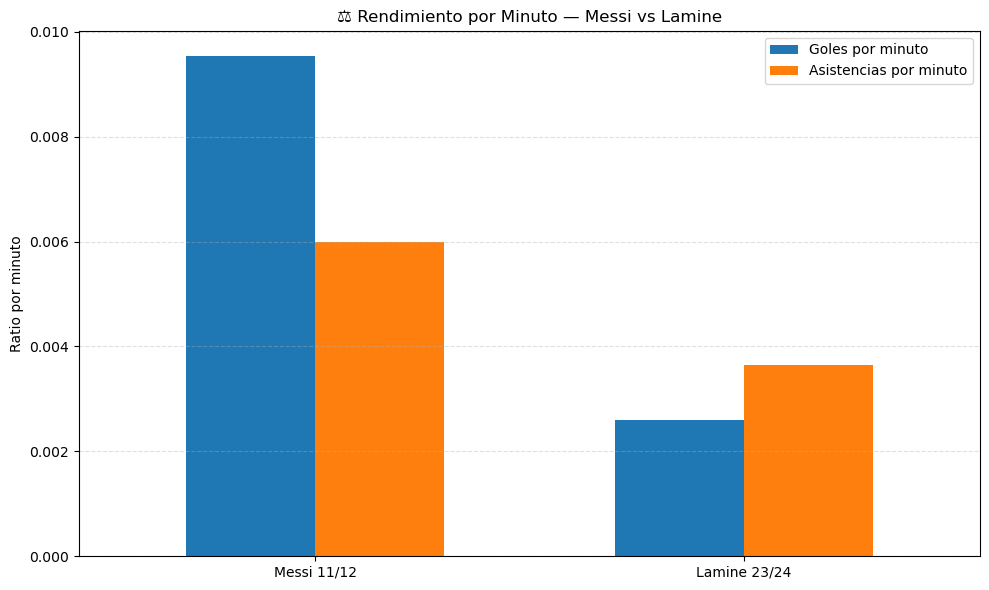

🔎 Datos detallados por minuto:


,Goles por minuto,Asistencias por minuto
Messi 11/12,0.0095,0.0060
Lamine 23/24,0.0026,0.0036


In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar temporadas específicas
messi_1112 = df_cleaned[df_cleaned["Season"] == "2011-2012"]
lamine_2324 = df_cleaned_yamal[df_cleaned_yamal["Season"] == "2023-2024"]

# Extraer métricas
goles_messi = messi_1112["Goals"].sum()
goles_lamine = lamine_2324["Goals"].sum()
asis_messi = messi_1112["Assists"].sum()
asis_lamine = lamine_2324["Assists"].sum()
min_messi = messi_1112["Minutes"].sum()
min_lamine = lamine_2324["Minutes"].sum()

# Calcular métricas por minuto
stats_por_minuto = {
    "Goles por minuto": [goles_messi / min_messi, goles_lamine / min_lamine],
    "Asistencias por minuto": [asis_messi / min_messi, asis_lamine / min_lamine],
}

# Crear DataFrame comparativo
df_minuto = pd.DataFrame(stats_por_minuto, index=["Messi 11/12", "Lamine 23/24"])

# 📈 Gráfico
df_minuto.plot(kind="bar", figsize=(10, 6), title="⚖️ Rendimiento por Minuto — Messi vs Lamine", width=0.6)
plt.ylabel("Ratio por minuto")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

# 🧾 Mostrar tabla redondeada
print("🔎 Datos detallados por minuto:")
display(df_minuto.round(4))

